In [2]:
import os
import torch
import numpy as np
from tqdm.notebook import tqdm
import imageio
import torch.nn as nn
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
from skimage import img_as_ubyte

# io utils
import pytorch3d
from pytorch3d.io import load_obj

# datastructures
from pytorch3d.structures import Meshes

# 3D transformations functions
from pytorch3d.transforms import Rotate, Translate,quaternion_to_matrix

# rendering components
from pytorch3d.renderer import (
    FoVPerspectiveCameras, look_at_view_transform, look_at_rotation,
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights, TexturesVertex,
    SoftPhongShader, SoftGouraudShader
)
from pytorch3d.utils import ico_sphere
from renderer import LayeredShader
import wandb

In [3]:
# Set the cuda device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

# Load Object

In [4]:
# Load the obj and ignore the textures and materials.
target_verts, target_faces_idx, _ = load_obj("./data/teapot.obj")
target_verts = target_verts.to(device)
target_faces = target_faces_idx.verts_idx.to(device)

# Scale and center vertices
target_center = target_verts.mean(0)
target_verts = target_verts - target_center
target_scale = max(target_verts.abs().max(0)[0])
target_verts = target_verts / target_scale

# Initialize each vertex to be white in color.
target_verts_rgb = torch.ones_like(target_verts)[None]*torch.tensor((0.5,0.5,0.5), device=device)  # (1, V, 3)
target_textures = TexturesVertex(verts_features=target_verts_rgb)

# Create a Meshes object for the target. Here we have only one mesh in the batch.
target_mesh = Meshes(
    verts=[target_verts],
    faces=[target_faces],
    textures=target_textures
)

An exception occurred in telemetry logging.Disabling telemetry to prevent further exceptions.
Traceback (most recent call last):
  File "/home/frederiknolte/.miniconda3/envs/2d23d/lib/python3.10/site-packages/iopath/common/file_io.py", line 946, in __log_tmetry_keys
    handler.log_event()
  File "/home/frederiknolte/.miniconda3/envs/2d23d/lib/python3.10/site-packages/iopath/common/event_logger.py", line 97, in log_event
    del self._evt
AttributeError: _evt
/home/frederiknolte/.miniconda3/envs/2d23d/lib/python3.10/site-packages/pytorch3d/io/obj_io.py:544: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


In [5]:
# Source mesh

# Load the obj and ignore the textures and materials.
source_verts, source_faces_idx, _ = load_obj("./data/other_teapot.obj")
source_verts = source_verts.to(device)
source_faces = source_faces_idx.verts_idx.to(device)

# Scale and center vertices
source_center = source_verts.mean(0)
source_verts = source_verts - source_center
source_scale = max(source_verts.abs().max(0)[0])
source_verts = source_verts / source_scale

# Initialize each vertex to be white in color.
source_verts_rgb = torch.ones_like(source_verts)[None]*torch.tensor((0.5,0.5,0.5), device=device)  # (1, V, 3)
source_textures = TexturesVertex(verts_features=source_verts_rgb)

# Create a Meshes object for the source. Here we have only one mesh in the batch.
source_mesh = Meshes(
    verts=[source_verts.to(device)],
    faces=[source_faces.to(device)],
    textures=source_textures
)

An exception occurred in telemetry logging.Disabling telemetry to prevent further exceptions.
Traceback (most recent call last):
  File "/home/frederiknolte/.miniconda3/envs/2d23d/lib/python3.10/site-packages/iopath/common/file_io.py", line 946, in __log_tmetry_keys
    handler.log_event()
  File "/home/frederiknolte/.miniconda3/envs/2d23d/lib/python3.10/site-packages/iopath/common/event_logger.py", line 97, in log_event
    del self._evt
AttributeError: _evt


# Initialise Renderers

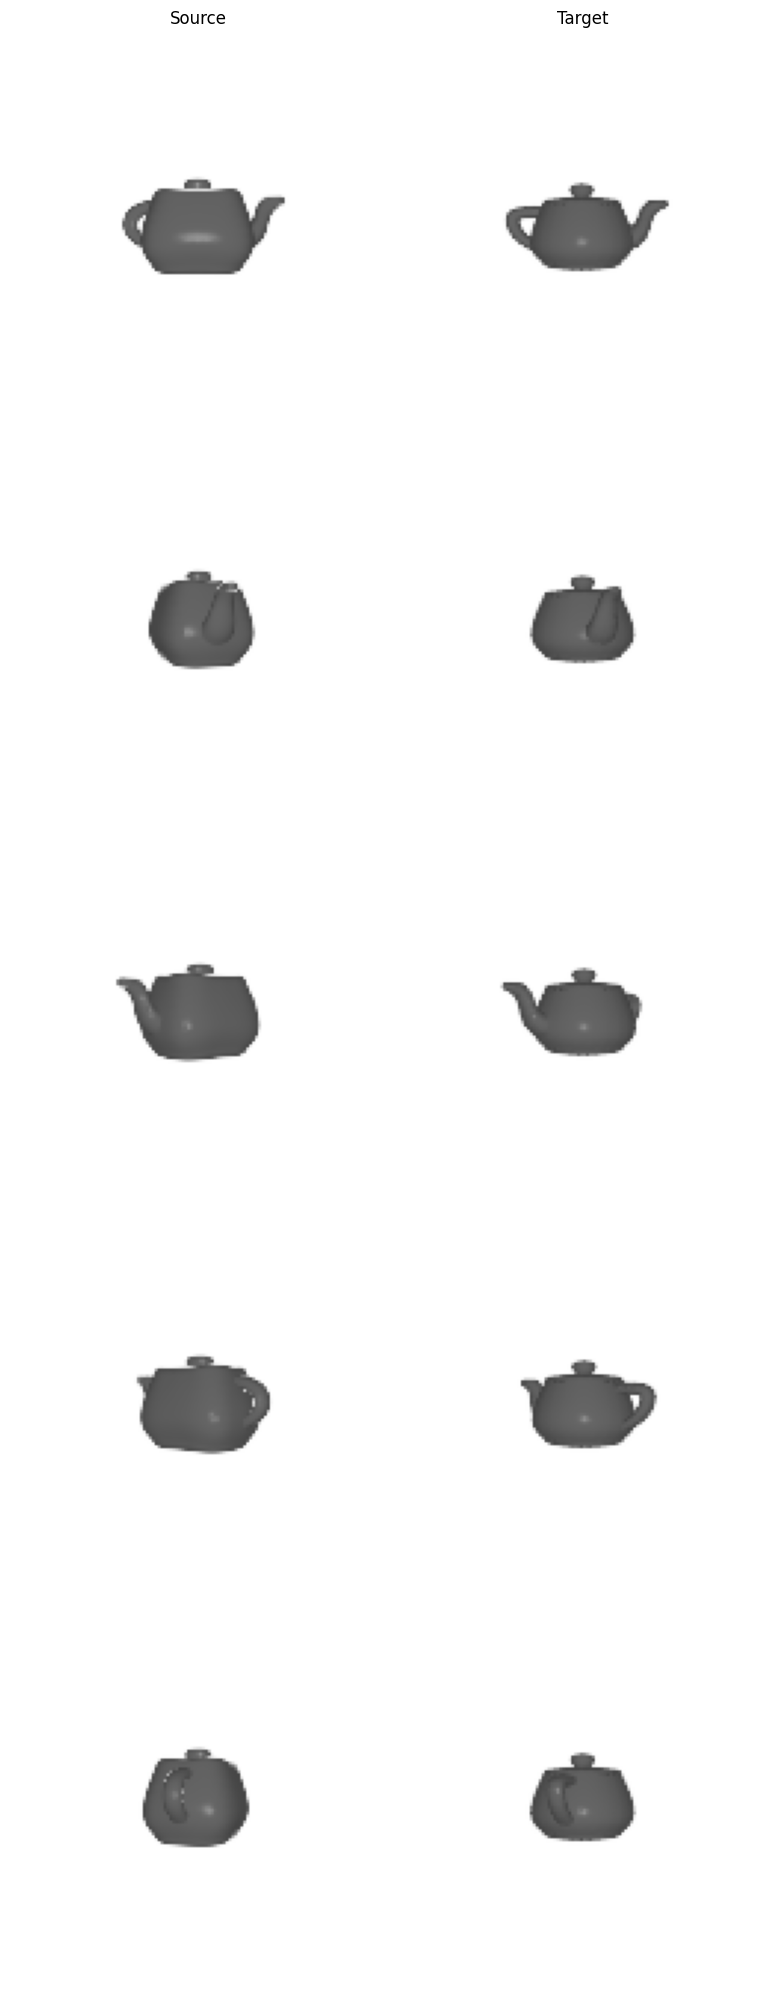

In [6]:
num_views = 5

R, T = look_at_view_transform(dist=4,
                              elev=torch.zeros(num_views, device=device),
                              azim=torch.tensor([360. * i / num_views for i in range(0, num_views)], device=device))

# Initialize a perspective camera.
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
camera = FoVPerspectiveCameras(device=device, R=R[None, 1, ...], T=T[None, 1, ...])

# We will also create a Phong renderer. This is simpler and only needs to render one face per pixel.
sigma = 1e-4
raster_settings_soft = RasterizationSettings(
    image_size=128,
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma,
    faces_per_pixel=150,
    perspective_correct=False,
    bin_size=0
)
# We can add a point light in front of the object.
lights = PointLights(device=device, location=cameras.get_camera_center())
phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera,
        raster_settings=raster_settings_soft
    ),
    shader=LayeredShader(device=device, cameras=camera, lights=lights)
)

# Render the target providing the values of R and T.
target_image_ref = phong_renderer(meshes_world=target_mesh.extend(num_views), cameras=cameras)
target_image_ref = target_image_ref.squeeze().permute(0, 2, 3, 1)[:,:,:,:3].cpu().numpy()

# Render the source providing the values of R and T.
source_image_ref = phong_renderer(meshes_world=source_mesh.extend(num_views), cameras=cameras)
source_image_ref = source_image_ref.squeeze().permute(0, 2, 3, 1)[:,:,:,:3].cpu().numpy()


fig, axs = plt.subplots(nrows=num_views, ncols=2, sharex=True, sharey=True)
fig.set_size_inches(8, num_views * 4)
axs[0, 0].set_title("Source")
axs[0, 1].set_title("Target")

for i in range(num_views):
    axs[i, 0].imshow(source_image_ref[i])
    axs[i, 1].imshow(target_image_ref[i])
    axs[i, 0].axis("off")
    axs[i, 1].axis("off")

plt.tight_layout()
plt.show()

# Define Model

In [7]:
class Model(nn.Module):
    def __init__(self, meshes, renderer, image_ref, cameras, optimisation):
        super().__init__()
        self.meshes = meshes
        self.device = meshes.device
        self.renderer = renderer
        self.cameras = cameras
        self.optimisation = optimisation
        assert self.optimisation in ['RT', 'shape']

        # Get the reference/target depth image
        image_ref = image_ref.clone()
        self.register_buffer('image_ref', image_ref)

        if self.optimisation == 'RT':
            # Create an optimizable parameter for the x, y, z translation of the mesh.
            self.translation_params = nn.Parameter(
                torch.from_numpy(np.array([[1.0,0.5,0.5]], dtype=np.float32)).to(self.device))
                    # Create an optimizable parameter for the x, y, z translation of the mesh.
            self.rotation_params = nn.Parameter(
                torch.from_numpy(np.array([[1.0,0.0,2.0,0.0]], dtype=np.float32)).to(self.device))
        else:
            self.deform_verts = nn.Parameter(
                torch.full(meshes.verts_packed().shape, 0.0, device=self.device)
            )

        self.loss_fn = nn.MSELoss()

    def forward(self):
        if self.optimisation == 'RT':
            self.RT_loss()
        else:
            self.shape_loss()

        # render mesh with static camera
        fragments = self.renderer(meshes_world=self.tmesh.extend(len(self.cameras)), cameras=self.cameras)
        self.dimg = fragments.squeeze().permute(0, 2, 3, 1)[:,:,:,:3]

        loss = torch.sum((self.dimg - self.image_ref) ** 2, dim=[1, 2, 3]).mean()
        return loss, self.dimg

    def RT_loss(self):
        trans = Translate(self.translation_params, device=self.device)
        rot = Rotate(quaternion_to_matrix(self.rotation_params), device=self.device)
        rverts = rot.transform_points(self.meshes.verts_list()[0])
        tverts = trans.transform_points(rverts)
        faces = self.meshes.faces_list()[0]

        self.tmesh = pytorch3d.structures.Meshes(
            verts=[tverts.to(self.device)],
            faces=[faces.to(self.device)],
            textures=self.meshes.textures
        )

    def shape_loss(self):
        self.tmesh = self.meshes.offset_verts(self.deform_verts)

<Figure size 1000x1000 with 0 Axes>

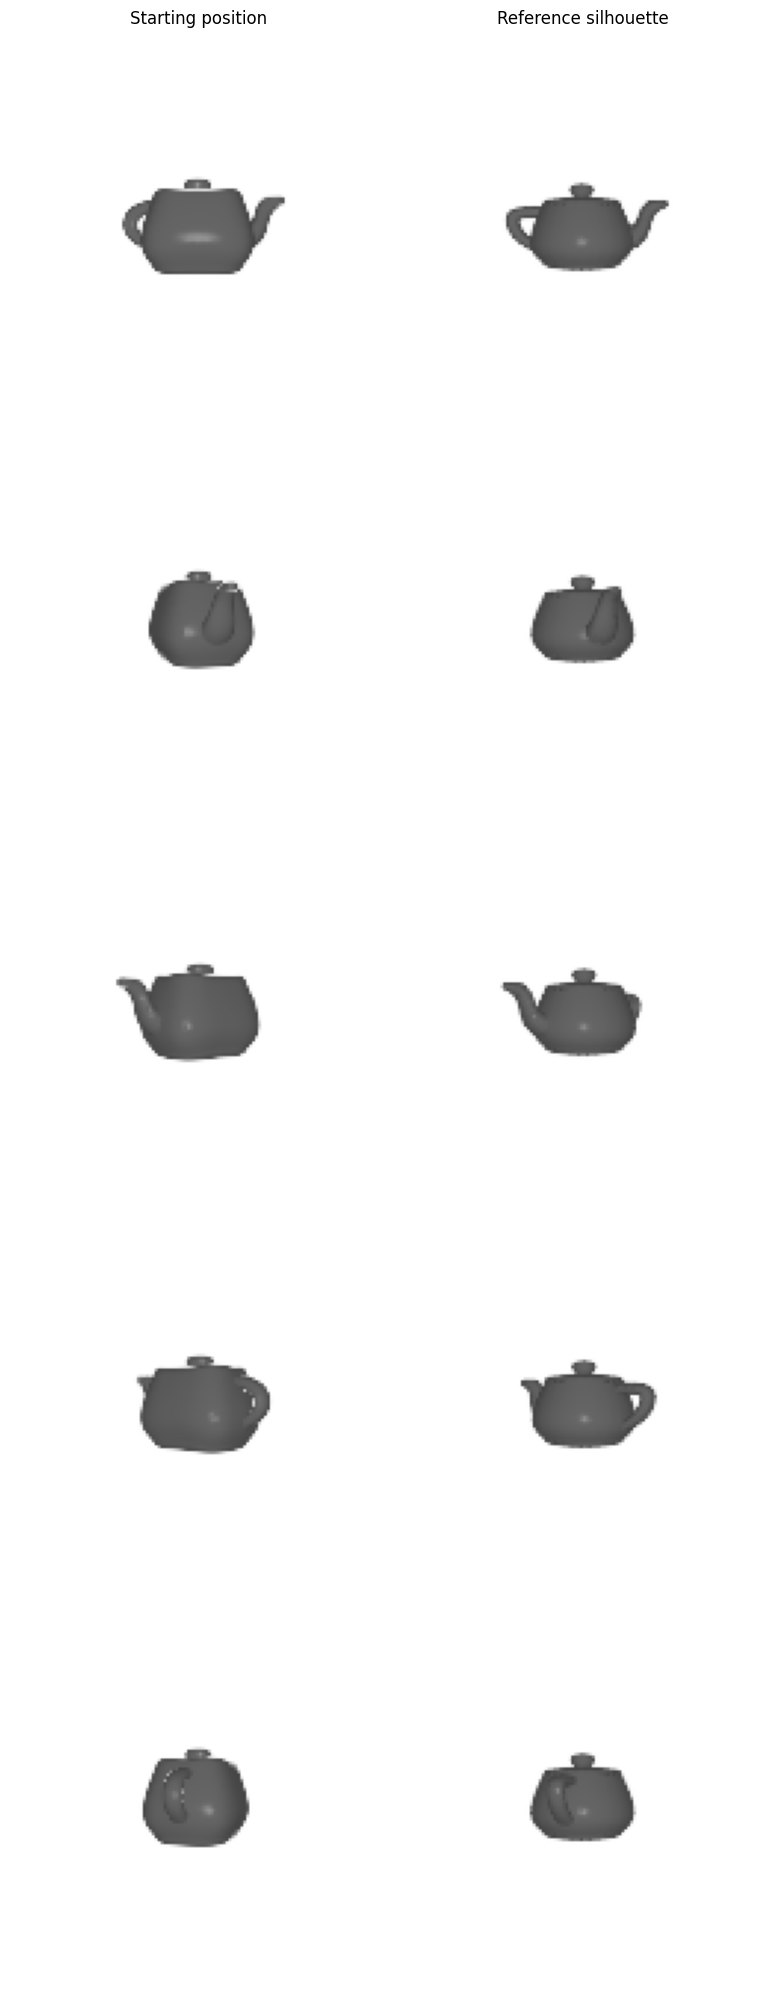

  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_224569/476774445.py:40: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 1.0)


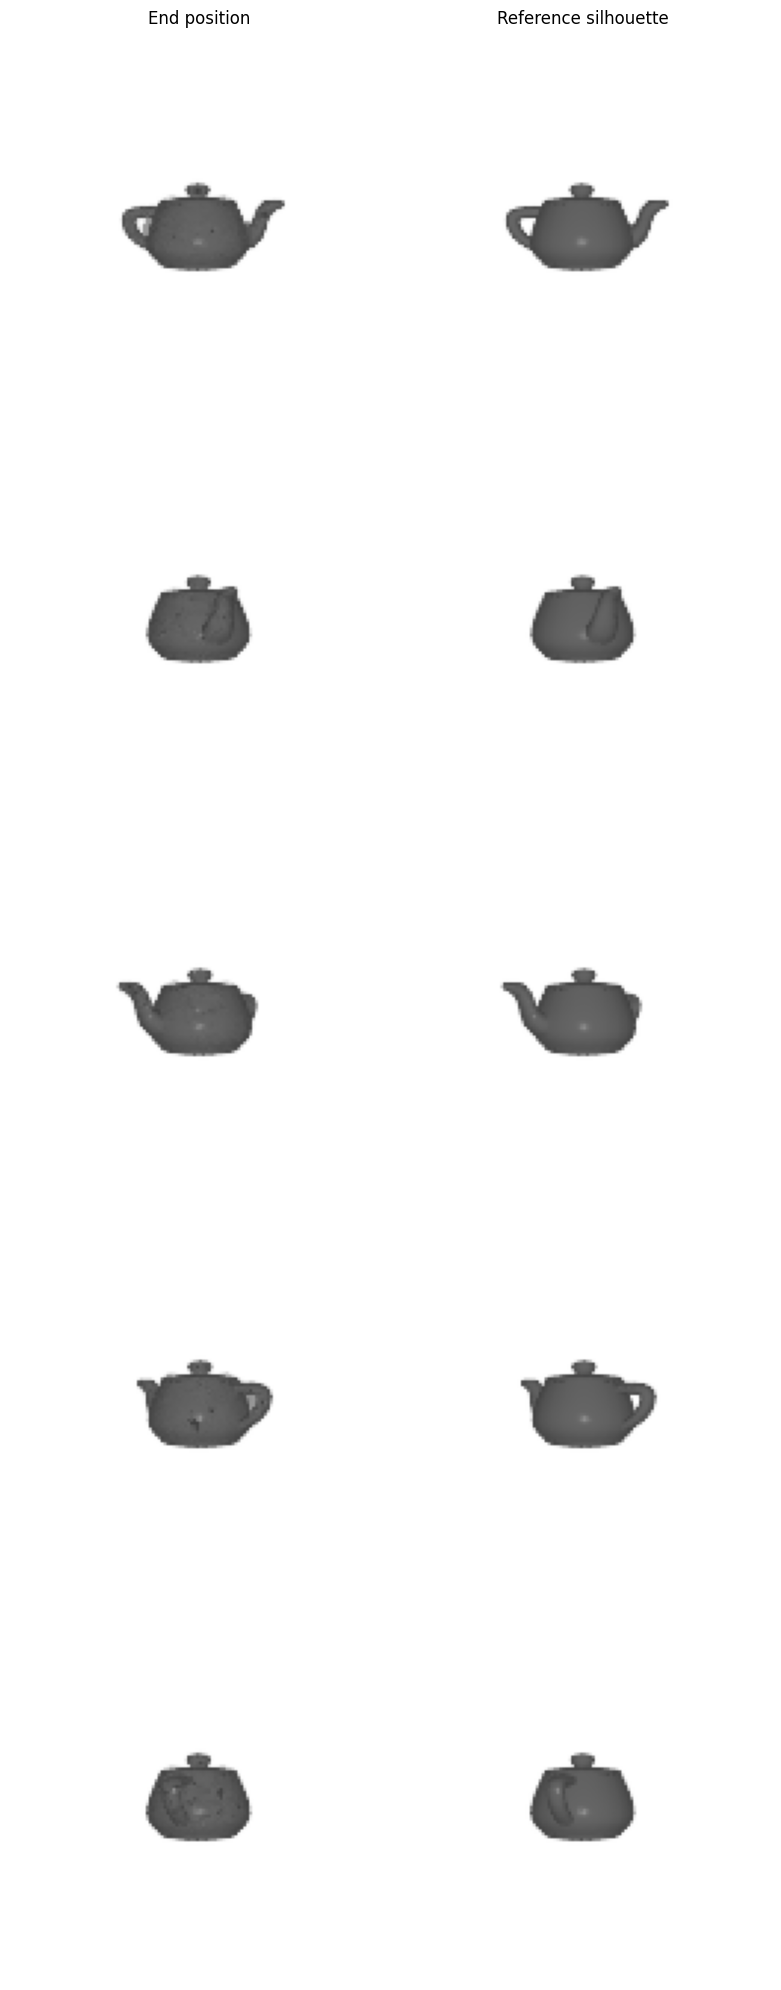

In [9]:
optimisation = 'shape'

# Initialise wandb
wandb.init(
    project='2d23d',
    entity='frederiknolte',

)

# We will save images periodically and compose them into a GIF.
filename_output = "./output/shape_optimization_demo.mp4"
# writer = imageio.get_writer(filename_output, mode='I', duration=0.3)
writer = imageio.get_writer(filename_output, format="mp4", mode="I", fps=10)

# Initialize a model using the renderer, mesh and reference image
model = Model(meshes=source_mesh,
              renderer=phong_renderer,
              image_ref=torch.tensor(target_image_ref),
              cameras=cameras,
              optimisation='shape').to(device)

# Create an optimizer. Here we are using Adam and we pass in the parameters of the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

plt.figure(figsize=(10, 10))

loss, dimg = model()

fig, axs = plt.subplots(nrows=num_views, ncols=2, sharex=True, sharey=True)
fig.set_size_inches(8, num_views * 4)
axs[0, 0].set_title("Starting position")
axs[0, 1].set_title("Reference silhouette")

for i in range(num_views):
    axs[i, 0].imshow(dimg[i].detach().cpu().numpy())
    axs[i, 1].imshow(target_image_ref[i])
    axs[i, 0].axis("off")
    axs[i, 1].axis("off")

plt.tight_layout()
plt.show()

loop = tqdm(range(500))
flattened_target = np.concatenate(list(target_image_ref * 255.), axis=1).astype(np.uint8)
for i in loop:
    optimizer.zero_grad()
    loss, dimg = model()
    loss.backward()
    torch.nn.utils.clip_grad_norm(model.parameters(), 1.0)
    optimizer.step()

    loop.set_description('Optimizing (loss %.4f)' % loss.data)

    # Save outputs to create an mp4.
    image = dimg.detach().cpu().numpy()
    image = img_as_ubyte(image)
    image = np.concatenate(list(image), axis=1)
    image = np.concatenate([flattened_target, image], axis=0)
    writer.append_data(image)


fig, axs = plt.subplots(nrows=num_views, ncols=2, sharex=True, sharey=True)
fig.set_size_inches(8, num_views * 4)
axs[0, 0].set_title("End position")
axs[0, 1].set_title("Reference silhouette")

for i in range(num_views):
    axs[i, 0].imshow(dimg[i].detach().cpu().numpy())
    axs[i, 1].imshow(target_image_ref[i])
    axs[i, 0].axis("off")
    axs[i, 1].axis("off")

plt.tight_layout()
plt.show()

writer.close()

In [2]:
import wandb

wandb.init(
        project='2d23d',
        entity='frederiknolte',
    )

Traceback (most recent call last):
  File "/home/frederiknolte/.miniconda3/envs/2d23d/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/frederiknolte/.miniconda3/envs/2d23d/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/frederiknolte/.miniconda3/envs/2d23d/lib/python3.10/site-packages/wandb/__main__.py", line 1, in <module>
    from wandb.cli import cli
  File "/home/frederiknolte/.miniconda3/envs/2d23d/lib/python3.10/site-packages/wandb/cli/cli.py", line 1799, in <module>
    default=find_executable("nvidia-docker") is not None,
  File "/home/frederiknolte/.miniconda3/envs/2d23d/lib/python3.10/site-packages/dockerpycreds/utils.py", line 12, in find_executable
    return distutils.spawn.find_executable(executable, path)
AttributeError: module 'distutils' has no attribute 'spawn'


ServiceStartProcessError: The wandb service process exited with 1. Ensure that `sys.executable` is a valid python interpreter. You can override it with the `_executable` setting or with the `WANDB__EXECUTABLE` environment variable.